In [11]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
from graspy.plot import heatmap
import matplotlib.pyplot as plt
%matplotlib inline 

### Data Paths

In [14]:
data_dir = Path('/mnt/c/Users/Ronan Perry/Documents/JHU/jovo-lab/multiview/data')

fmri_dir = data_dir / 'raw' / 'fMRI' / 'REST_Data'
fmri_metadata_path = data_dir / 'raw' / 'fMRI' / 'SubjectsIDs_Schaefer_rest_Alone.csv'

sc_dir = data_dir / 'raw' / 'structural' / 'Deterministic_FA'
sc_metadata_path = data_dir / 'raw' / 'structural' / 'SubjectsIDs_Schaefer_Diffusion.csv'

demographics_path = data_dir / 'raw' / 'Demographics_MedicalFilter.csv'
clinical_path = data_dir / 'raw' / 'Cognitive_MedicalFilter.csv'
schaefer_coords_path = data_dir / 'supplementary' / 'Schaefer2018_400Parcels_17Networks_order.txt'

### Load Metadata

In [15]:
fmri_metadata = pd.read_csv(fmri_metadata_path)
sc_metadata = pd.read_csv(sc_metadata_path)
demographics = pd.read_csv(demographics_path)
clinical_scores = pd.read_csv(clinical_path)

### Load fMRI Scan

In [5]:
fmri_files = [f for f in os.listdir(fmri_dir)]
fmri_ids = [f.split('_')[0] for f in os.listdir(fmri_dir)]

In [6]:
idx = 0
subj = np.genfromtxt(fmri_dir / fmri_files[idx], delimiter=' ')

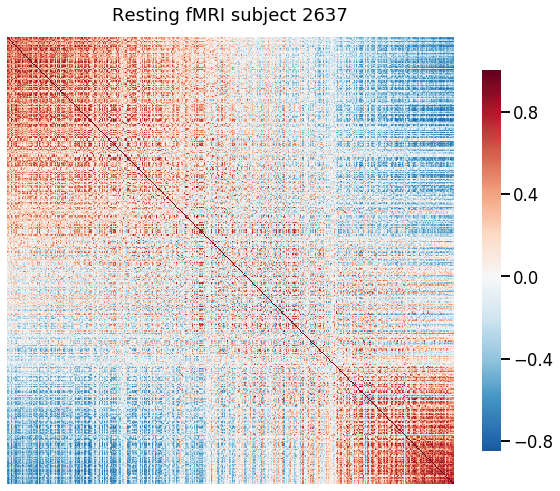

In [12]:
fig = heatmap(subj, title=f'Resting fMRI subject {fmri_ids[idx]}')
plt.show()

In [ ]:
su

In [32]:
demographics.query(f'bblid == {subj_bblid}')

ValueError: multi-line expressions are only valid in the context of data, use DataFrame.eval

In [31]:
## RMS Motion
subj_rms_motion = fmri_metadata.query(f'scanid == {fmri_ids[idx]}')['restRelMeanRMSMotion']
print(f'Motion: {subj_rms_motion}')
subj_bblid = fmri_metadata.query(f'scanid == {fmri_ids[idx]}')['bblid']
## Sex
subj_sex = demographics.query(f'bblid == {subj_bblid}')['sex']
print(f'Sex: {subj_sex}')
## Age
subj_age = demographics.query(f'bblid == {subj_bblid}')['ageAtCnb1']
print(f'Age: {subj_age}')

Motion: 0    0.022592
Name: restRelMeanRMSMotion, dtype: float64


ValueError: multi-line expressions are only valid in the context of data, use DataFrame.eval

In [13]:
demographics

,bblid,sex,race,race2,ethnicity,ageAtClinicalAssess1,ageAtCnb1,edu1,fedu1,medu1,handednessv2,psych_psychoactive_drug_count,medical_psychoactive_drug_count,medicalrating,medicalratingExclude,smrytrt_psychinpt,incidentalFindingExclude
0,80010,1,1,1,2,260.0,260.0,14.0,20.0,16.0,1.0,NaN,NaN,2,0,0.0,0.0
1,80036,2,2,2,2,253.0,253.0,12.0,NaN,12.0,1.0,NaN,NaN,1,0,0.0,NaN
2,80043,2,2,2,2,260.0,260.0,15.0,12.0,16.0,1.0,NaN,NaN,0,0,0.0,NaN
3,80051,2,2,2,2,253.0,253.0,12.0,NaN,16.0,2.0,NaN,NaN,1,0,0.0,NaN
4,80092,1,2,2,2,250.0,250.0,14.0,15.0,14.0,1.0,NaN,NaN,2,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7146,139571,1,2,2,2,116.0,116.0,3.0,12.0,12.0,1.0,NaN,NaN,0,0,0.0,NaN
7147,139601,1,2,2,2,104.0,104.0,2.0,18.0,16.0,1.0,NaN,NaN,0,0,0.0,NaN
7148,139604,2,2,2,2,105.0,105.0,2.0,14.0,14.0,2.0,NaN,NaN,1,0,0.0,NaN
7149,139616,2,2,2,2,116.0,116.0,3.0,13.0,14.0,1.0,NaN,NaN,1,0,0.0,NaN


In [16]:
clinical_scores

,bblid,cnbAgeMonths,cnbage,abf_z,att_z,wm_z,vmem_z,fmem_z,smem_z,lan_z,...,edi_s_z,adi_s_z,mot_s_z,sm_s_z,psych_psychoactive_drug_count,medical_psychoactive_drug_count,medicalrating,medicalratingExclude,smrytrt_psychinpt,incidentalFindingExclude
0,80010,261.0,21.0,0.117846,0.729742,0.558248,0.954445,-0.009259,-0.631470,1.369313,...,-0.472595,-1.007542,0.997133,1.346956,NaN,NaN,2,0,0.0,0.0
1,80036,254.0,21.0,-0.768086,0.851021,0.176454,-1.441070,0.475532,0.188108,-1.152986,...,1.857365,1.734259,0.592961,1.405194,NaN,NaN,1,0,0.0,NaN
2,80043,260.0,21.0,0.529673,0.608463,0.940042,0.355566,1.137831,0.188108,0.308965,...,1.161750,1.263215,0.759382,1.042061,NaN,NaN,0,0,0.0,NaN
3,80051,254.0,21.0,-1.234017,0.972300,-0.587133,0.355566,1.137831,0.188108,-2.149818,...,0.712059,0.694713,1.139781,-0.787304,NaN,NaN,1,0,0.0,NaN
4,80092,250.0,21.0,0.435111,0.608463,0.940042,0.954445,0.233136,1.007685,1.008985,...,-0.062955,0.472998,0.569189,-0.410469,NaN,NaN,2,0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7146,139571,116.0,10.0,0.277586,-3.151181,-0.587133,0.655006,0.014732,1.007685,-0.853014,...,0.638087,-0.061938,-0.928618,0.117101,NaN,NaN,0,0,0.0,NaN
7147,139601,104.0,9.0,-1.844064,-0.483047,-1.732515,0.056127,-0.434508,-1.041258,-2.121333,...,0.352848,-0.014715,-0.928618,-0.403617,NaN,NaN,0,0,0.0,NaN
7148,139604,105.0,9.0,-0.525732,-1.574556,-3.259691,-2.039949,-1.221238,-1.451047,-1.195198,...,-0.134499,-1.132099,-1.118816,0.031457,NaN,NaN,1,0,0.0,NaN
7149,139616,117.0,10.0,0.179086,-0.846883,0.558248,-2.039949,-0.978843,0.188108,0.038792,...,0.106429,-0.129998,-0.476899,0.555601,NaN,NaN,1,0,0.0,NaN
